# Proyek Klasifikasi Gambar: Intel Image Classification

1.   Buldings (0)
2.   Forest (1)
3.   Glacier (2)
4.   Mountation (3)
5.   Sea (4)
6.   Street (5)


- **Nama:** Wildan Bagus Wicaksono
- **Email:** wildanarteji@gmail.com
- **ID Dicoding:** wildabandon

## Import Semua Packages/Library yang Digunakan

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%cd /content/drive/MyDrive/Dicoding/Klasifikasi Gambar

In [94]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [134]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers, models, applications, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, MobileNetV2

import tensorflowjs as tfjs

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from tensorflow.keras.models import load_model

In [5]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wildabandon","key":"62778fbd066237701eab49bec903d8f3"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
%cd /content
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -o intel-image-classification.zip
# pass kriteria 2

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain

In [9]:
train_dir = '/content/seg_train'
test_dir = '/content/seg_test'

merged_folder = '/content/folder'

In [10]:
os.makedirs(merged_folder, exist_ok=True)

In [11]:
# !rm -rf folder
!rm -rf /content/intel-image-classification.zip
!rm -rf /content/folder/dataset
!rm -rf /content/sample_data

In [12]:
def copy_files(src_folder, dst_folder):
    for root, dirs, files in os.walk(src_folder):
        for file in files:
            src_path = os.path.join(root, file)
            relative_path = os.path.relpath(src_path, src_folder)
            dst_path = os.path.join(dst_folder, relative_path)

            # Create any subdirectories if needed
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)

            # Copy the file
            shutil.copy2(src_path, dst_path)

# Copy contents of both folders
copy_files(train_dir, merged_folder)
copy_files(test_dir, merged_folder)

In [13]:
combined_dir = '/content/folder/dataset'
os.makedirs(combined_dir, exist_ok=True)

In [14]:
train_dir = '/content/folder/seg_train'
test_dir = '/content/folder/seg_test'

In [15]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [16]:
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [17]:
len(os.listdir('folder/dataset'))
# pass penilaian opsional 5

6

In [18]:
count = 0
count_temp = 0
for category in os.listdir('folder/dataset'):
  count_temp = len(os.listdir(os.path.join('folder/dataset', category)))
  print(f'{category} : {count_temp}')
  count += count_temp
print('Total : ', count)
# ada 17034 gambar => pass penilaian opsional 1 dan kriteria 1

mountain : 3037
buildings : 2628
street : 2883
sea : 2784
forest : 2745
glacier : 2957
Total :  17034


In [19]:
img_path = 'folder/dataset/buildings/0.jpg'
img = Image.open(img_path)
width_img, height_img = img.size

for category in os.listdir('folder/dataset'):
  for img2 in os.listdir(os.path.join('folder/dataset', category)):
    img_path2 = os.path.join('folder/dataset', category, img2)
    img3 = Image.open(img_path2)
    width_img3, height_img3 = img3.size
    if width_img != width_img3 or width_img != height_img3:
      print(img_path2)
      break
# ada resolusi yang berbeda => pass penilaian opsional 2

folder/dataset/mountain/16041.jpg
folder/dataset/buildings/5358.jpg
folder/dataset/street/13747.jpg
folder/dataset/sea/341.jpg
folder/dataset/forest/7174.jpg
folder/dataset/glacier/17528.jpg


In [20]:
# contoh img dengan resolusi yang berbeda
img4_path = 'folder/dataset/buildings/5358.jpg'
img4 = Image.open(img4_path)
width_img4, height_img4 = img4.size
print(width_img4, height_img4)
print(width_img, height_img)

150 124
150 150


In [21]:
gambar = {}
path = 'folder/'
path_sub = os.path.join(path, 'dataset')

In [22]:
for i in os.listdir(path_sub):
  gambar[i] = os.listdir(os.path.join(path_sub, i))


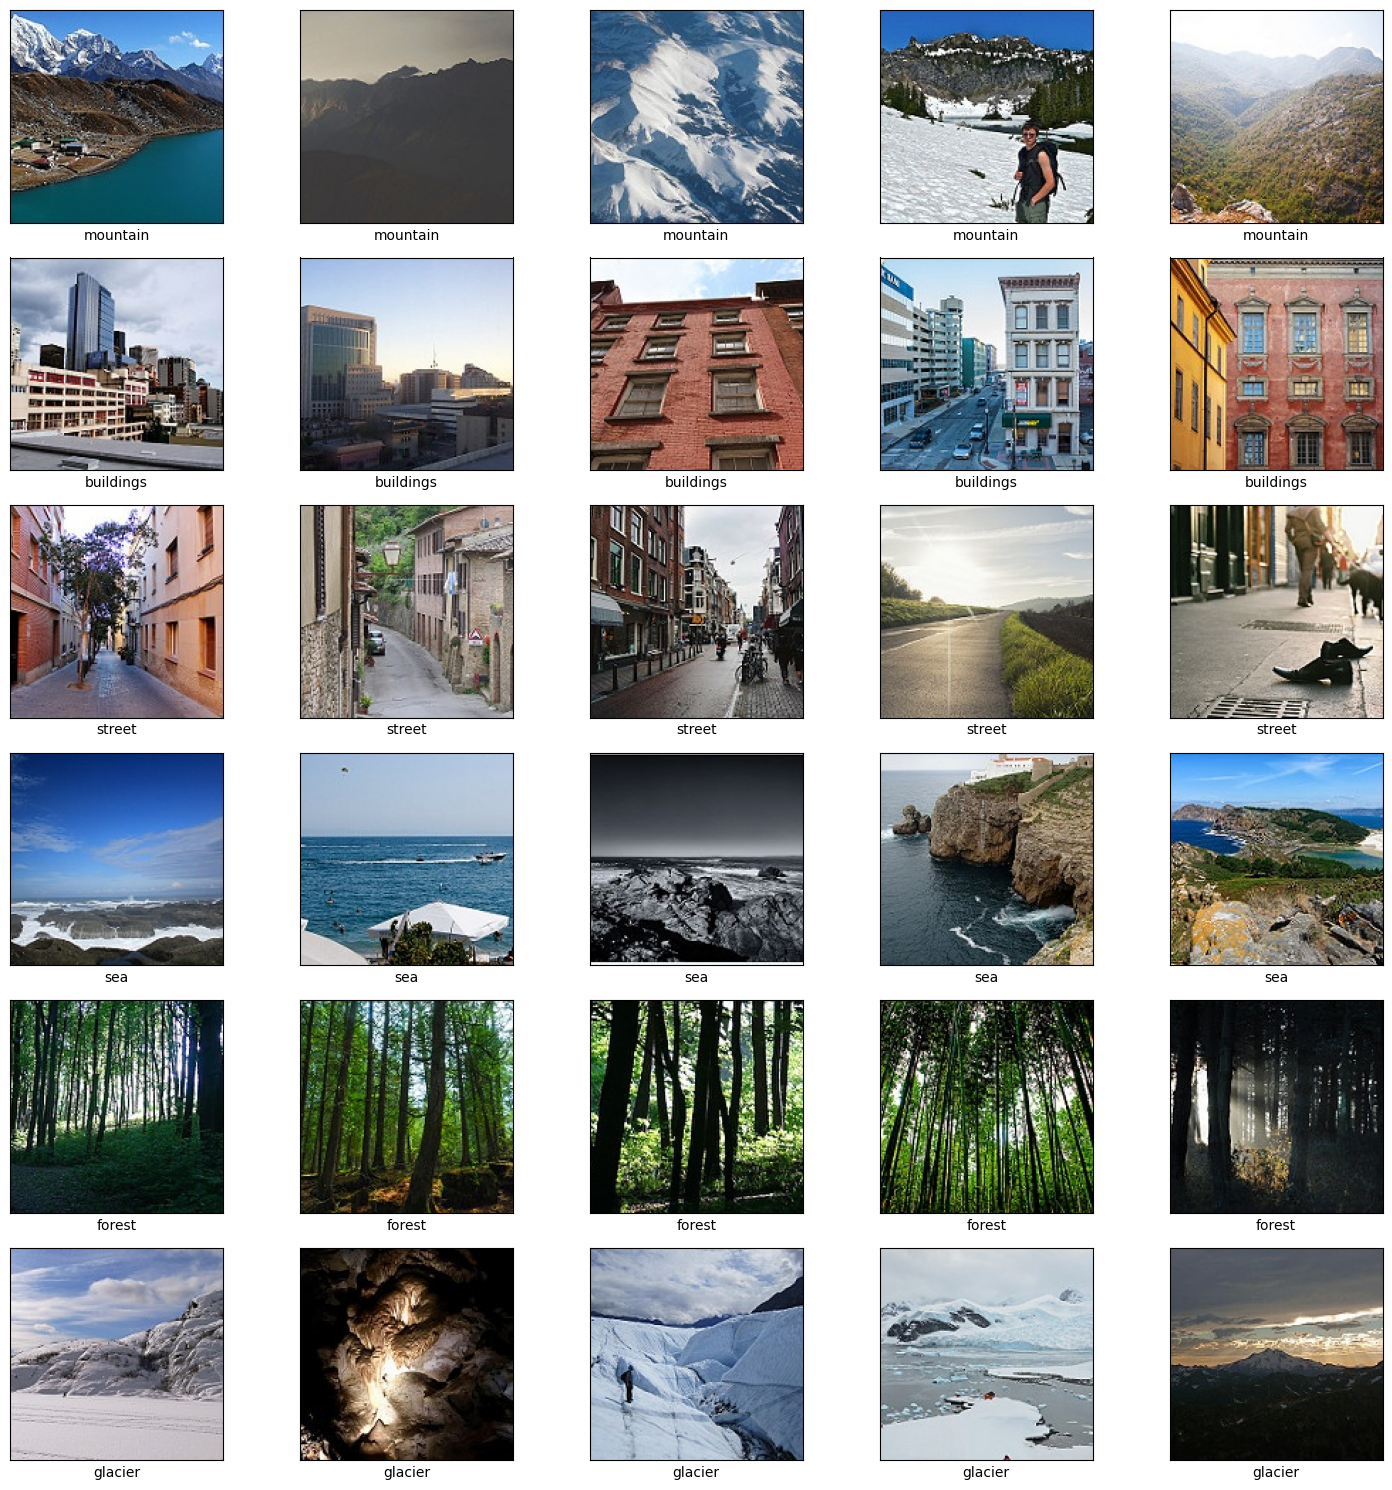

In [23]:
fig, axs = plt.subplots(len(gambar.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(gambar[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert("RGB")
    axs[i, j].imshow(img)
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()


### Data Preprocessing

#### Split Dataset

In [24]:
mypath = 'folder/dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)


In [25]:
df = pd.DataFrame({
    'path': full_path,
    'file_name': file_name,
    'labels': labels
                   })
df

path  file_name    labels
0      folder/dataset/mountain/16114.jpg  16114.jpg  mountain
1       folder/dataset/mountain/8044.jpg   8044.jpg  mountain
2       folder/dataset/mountain/2724.jpg   2724.jpg  mountain
3      folder/dataset/mountain/15636.jpg  15636.jpg  mountain
4       folder/dataset/mountain/7355.jpg   7355.jpg  mountain
...                                  ...        ...       ...
17029    folder/dataset/glacier/2565.jpg   2565.jpg   glacier
17030   folder/dataset/glacier/15248.jpg  15248.jpg   glacier
17031   folder/dataset/glacier/20475.jpg  20475.jpg   glacier
17032   folder/dataset/glacier/13242.jpg  13242.jpg   glacier
17033   folder/dataset/glacier/14545.jpg  14545.jpg   glacier

[17034 rows x 3 columns]

In [26]:
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pass kriteria 3

#### Data Augmentation

In [27]:
df_train = pd.DataFrame({
    'path': X_train,
    'labels': y_train,
    'set': 'train'
                   })
df_test = pd.DataFrame({
    'path': X_test,
    'labels': y_test,
    'set': 'test'
                   })

In [28]:
df_all = pd.concat([df_train, df_test], ignore_index=True)

In [29]:
df_all.groupby(['set','labels']).size()


set    labels   
test   buildings     527
       forest        545
       glacier       591
       mountain      600
       sea           568
       street        576
train  buildings    2101
       forest       2200
       glacier      2366
       mountain     2437
       sea          2216
       street       2307
dtype: int64

In [30]:
print(df_all.sample(5))

                                    path    labels    set
6134         folder/dataset/sea/1619.jpg       sea  train
3208     folder/dataset/street/21745.jpg    street  train
3091     folder/dataset/forest/12945.jpg    forest  train
12734    folder/dataset/forest/22643.jpg    forest  train
6785   folder/dataset/mountain/11504.jpg  mountain  train


In [31]:
datasource_path = 'folder/dataset/'
dataset_path = 'Dataset-Final/'

In [32]:
for index, row in tq(df_all.iterrows()):
  file_path = row['path']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

In [33]:
TRAIN_DIR = '/content/Dataset-Final/train'
TEST_DIR = '/content/Dataset-Final/test'

train_buildings = os.path.join(TRAIN_DIR + '/buildings')
train_forest = os.path.join(TRAIN_DIR + '/forest')
train_glacier = os.path.join(TRAIN_DIR + '/glacier')
train_mountain = os.path.join(TRAIN_DIR + '/mountain')
train_sea = os.path.join(TRAIN_DIR + '/sea')
train_street = os.path.join(TRAIN_DIR + '/street')

test_buildings = os.path.join(TEST_DIR + '/buildings')
test_forest = os.path.join(TEST_DIR + '/forest')
test_glacier = os.path.join(TEST_DIR + '/glacier')
test_mountain = os.path.join(TEST_DIR + '/mountain')
test_sea = os.path.join(TEST_DIR + '/sea')
test_street = os.path.join(TEST_DIR + '/street')


In [125]:
datagen = ImageDataGenerator(rescale=1./255,
                             width_shift_range=.2,
                             height_shift_range=.2,
                             shear_range=.2,
                             zoom_range=.2,
                             horizontal_flip=True,
                             brightness_range=[.8, 1.2],
                             fill_mode='nearest',
                             rotation_range=20,
                              validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 10903 images belonging to 6 classes.
Found 2724 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


## Modelling

In [35]:
count_buildings = len(os.listdir(train_buildings))
count_forest = len(os.listdir(train_forest))
count_glacier = len(os.listdir(train_glacier))
count_mountain = len(os.listdir(train_mountain))
count_sea = len(os.listdir(train_sea))
count_street = len(os.listdir(train_street))

In [36]:
total = count_buildings + count_forest + count_glacier + count_mountain + count_sea + count_street

weight_buildings = (1 / count_buildings) * (total / 6)
weight_forest = (1 / count_forest) * (total / 6)
weight_glacier = (1 / count_glacier) * (total / 6)
weight_mountain = (1 / count_mountain) * (total / 6)
weight_sea = (1 / count_sea) * (total / 6)
weight_street = (1 / count_street) * (total / 6)

class_weights = {0: weight_buildings, 1: weight_forest, 2: weight_glacier, 3: weight_mountain, 4: weight_sea, 5: weight_street}


#### Model 1

In [160]:
# 1st layer
model_1 = Sequential()

model_1.add(Conv2D(32,
                   (3,3),
                   padding='same',
                   activation='relu',
                   input_shape=(150, 150, 3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2,2)))

# pass kriteria 4

# 2nd layer
model_1.add(Conv2D(32,
                   (4,4),
                   padding='same',
                   activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2,2)))

# 3rd layer
model_1.add(Conv2D(32,
                   (7,7),
                   padding='same',
                   activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2,2)))


# Flatten Layer
model_1.add(Flatten())
# 1st Dense Layer
model_1.add(Dense(128, activation='relu'))
# 1st Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense layer
model_1.add(Dense(64, activation='relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# final Dense Layer
model_1.add(Dense(6, activation='softmax'))

##################### fully connected layer ###########################

#####################  compile model ##################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])


print(model_1.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [161]:
''' class_weights = {0: weight_buildings,
1: weight_forest,
2: weight_glacier,
3: weight_mountain,
4: weight_sea,
5: weight_street}
'''

category = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
labels = list(range(len(category)))
labels

[0, 1, 2, 3, 4, 5]

In [162]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [163]:
model_ckpt = ModelCheckpoint(
    'model_2.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [164]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=1e-6
)

In [165]:

callbacks = [early_stop, model_ckpt, reduce_lr]


#tf.config.run_functions_eagerly(True)
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight=class_weights,
                        callbacks=callbacks)

Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 90s 252ms/step - accuracy: 0.2967 - loss: 2.7350 - val_accuracy: 0.2430 - val_loss: 2.7660 - learning_rate: 0.0010
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.4000 - loss: 1.4524 - val_accuracy: 0.4372 - val_loss: 1.2641 - learning_rate: 0.0010
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.4876 - loss: 1.2821 - val_accuracy: 0.5973 - val_loss: 1.0510 - learning_rate: 0.0010
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.5612 - loss: 1.1458 - val_accuracy: 0.6358 - val_loss: 0.9626 - learning_rate: 0.0010
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 81s 239ms/step - accuracy: 0.5976 - loss: 1.0625 - val_accuracy: 0.5587 - val_loss: 1.1231 - learning_rate: 0.0010
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.6262 - loss: 1.0105 - val_accuracy: 0.5778 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.66

#### Model 2

In [166]:
# 1st layer
model_2 = Sequential()

model_2.add(Conv2D(32,
                   (3,3),
                   padding='same',
                   activation='relu',
                   input_shape=(150, 150, 3)))
model_2.add(BatchNormalization())
model_2.add(Conv2D(32,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2)))

# 2nd layer
model_2.add(Conv2D(64,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(64,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2)))

# 3rd layer
model_2.add(Conv2D(128,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(128,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2,2)))



model_2.add(GlobalAveragePooling2D())

model_2.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
model_2.add(Dropout(0.5))

model_2.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))
model_2.add(Dropout(0.3))

# final Dense Layer
model_2.add(Dense(6, activation='softmax'))

##################### fully connected layer ###########################

#####################  compile model ##################################
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])


print(model_2.summary())


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 313,958 (1.20 MB)

 Trainable params: 313,062 (1.19 MB)

 Non-trainable params: 896 (3.50 KB)

None


In [167]:

callbacks = [early_stop, model_ckpt, reduce_lr]


#tf.config.run_functions_eagerly(True)
history_2 = model_2.fit(train_generator,
                        epochs=50,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight=class_weights,
                        callbacks=callbacks)

Epoch 1/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 99s 257ms/step - accuracy: 0.4226 - loss: 1.4450 - val_accuracy: 0.1707 - val_loss: 2.9803 - learning_rate: 0.0010
Epoch 2/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 83s 243ms/step - accuracy: 0.6156 - loss: 1.0228 - val_accuracy: 0.6373 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.6714 - loss: 0.8707 - val_accuracy: 0.6674 - val_loss: 0.9073 - learning_rate: 0.0010
Epoch 4/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.7085 - loss: 0.8083 - val_accuracy: 0.6872 - val_loss: 0.8486 - learning_rate: 0.0010
Epoch 5/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.7413 - loss: 0.7399 - val_accuracy: 0.6814 - val_loss: 0.8864 - learning_rate: 0.0010
Epoch 6/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - accuracy: 0.7751 - loss: 0.6512 - val_accuracy: 0.6358 - val_loss: 1.0667 - learning_rate: 0.0010
Epoch 7/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.78

#### Model 3

In [168]:
# 1st layer
model_3 = Sequential()

model_3.add(Conv2D(32,
                   (3,3),
                   padding='same',
                   activation='relu',
                   input_shape=(150, 150, 3)))
model_3.add(BatchNormalization())
model_3.add(Conv2D(32,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2)))

# 2nd layer
model_3.add(Conv2D(64,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2)))

# 3rd layer
model_3.add(Conv2D(128,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128,
                   (3,3),
                   padding='same',
                   activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2)))

# 4th layer

model_3.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2)))


model_3.add(GlobalAveragePooling2D())

model_3.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
model_3.add(Dropout(0.5))

model_3.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))
model_3.add(Dropout(0.3))

model_3.add(Dense(6, activation='softmax'))

##################### fully connected layer ###########################

#####################  compile model ##################################
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])


print(model_3.summary())


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 256)            │             

 Total params: 1,217,638 (4.64 MB)

 Trainable params: 1,215,718 (4.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


In [169]:
early_stop_3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr_3 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1
)

callbacks = [early_stop_3, reduce_lr_3]


#tf.config.run_functions_eagerly(True)
history_3 = model_3.fit(train_generator,
                        epochs=50,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight=class_weights,
                        callbacks=callbacks)

Epoch 1/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 100s 262ms/step - accuracy: 0.4028 - loss: 1.5514 - val_accuracy: 0.2232 - val_loss: 3.0658 - learning_rate: 0.0010
Epoch 2/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.6158 - loss: 1.0228 - val_accuracy: 0.5977 - val_loss: 1.0540 - learning_rate: 0.0010
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.6748 - loss: 0.8907 - val_accuracy: 0.7026 - val_loss: 0.8134 - learning_rate: 0.0010
Epoch 4/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.7210 - loss: 0.7993 - val_accuracy: 0.7107 - val_loss: 0.7467 - learning_rate: 0.0010
Epoch 5/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - accuracy: 0.7534 - loss: 0.7177 - val_accuracy: 0.6061 - val_loss: 1.2277 - learning_rate: 0.0010
Epoch 6/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.7702 - loss: 0.6899 - val_accuracy: 0.7423 - val_loss: 0.7202 - learning_rate: 0.0010
Epoch 7/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.

#### Model 4

In [156]:
base_model = applications.MobileNetV2(weights='imagenet',
                   include_top=False,
                   input_shape=(150, 150, 3))
base_model.trainable = True

fine_tune_at = 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

<ipython-input-156-e825122bc536>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(weights='imagenet',


In [157]:
model_4 = models.Sequential([
    base_model,
    layers.Dropout(0.3),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])

model_4.compile(optimizer=Adam(learning_rate=3e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model_4.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 5, 5, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,078,854 (11.74 MB)

 Trainable params: 3,025,206 (11.54 MB)

 Non-trainable params: 53,648 (209.56 KB)

In [158]:
early_stop_4 = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
#    min_delta=0.001
)
reduce_lr_4 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
#    verbose=1,
    min_lr=1e-6
)

model_ckpt_4 = ModelCheckpoint(
    'model_4_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


callbacks = [early_stop_4, reduce_lr_4,
             model_ckpt_4,
            # lr_scheduler
             ]

history_4 = model_4.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3196 - loss: 2.7515
Epoch 1: val_loss improved from inf to 1.88883, saving model to model_4_best.weights.h5
341/341 ━━━━━━━━━━━━━━━━━━━━ 145s 311ms/step - accuracy: 0.3201 - loss: 2.7505 - val_accuracy: 0.6744 - val_loss: 1.8888 - learning_rate: 3.0000e-05
Epoch 2/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7484 - loss: 1.7520
Epoch 2: val_loss improved from 1.88883 to 1.68488, saving model to model_4_best.weights.h5
341/341 ━━━━━━━━━━━━━━━━━━━━ 83s 245ms/step - accuracy: 0.7485 - loss: 1.7518 - val_accuracy: 0.7867 - val_loss: 1.6849 - learning_rate: 3.0000e-05
Epoch 3/50
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8202 - loss: 1.5512
Epoch 3: val_loss improved from 1.68488 to 1.43766, saving model to model_4_best.weights.h5
341/341 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step - accuracy: 0.8202 - loss: 1.5511 - val_accuracy: 0.8598 - val_loss: 1.4377 - learning_rate: 3.0000e-05
Epoch 4/50
341/341 

In [159]:
model_4.save('/content/best_model_4.keras')

## Evaluasi dan Visualisasi

In [170]:
category = list(train_generator.class_indices.keys())
category

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

#### Model 1

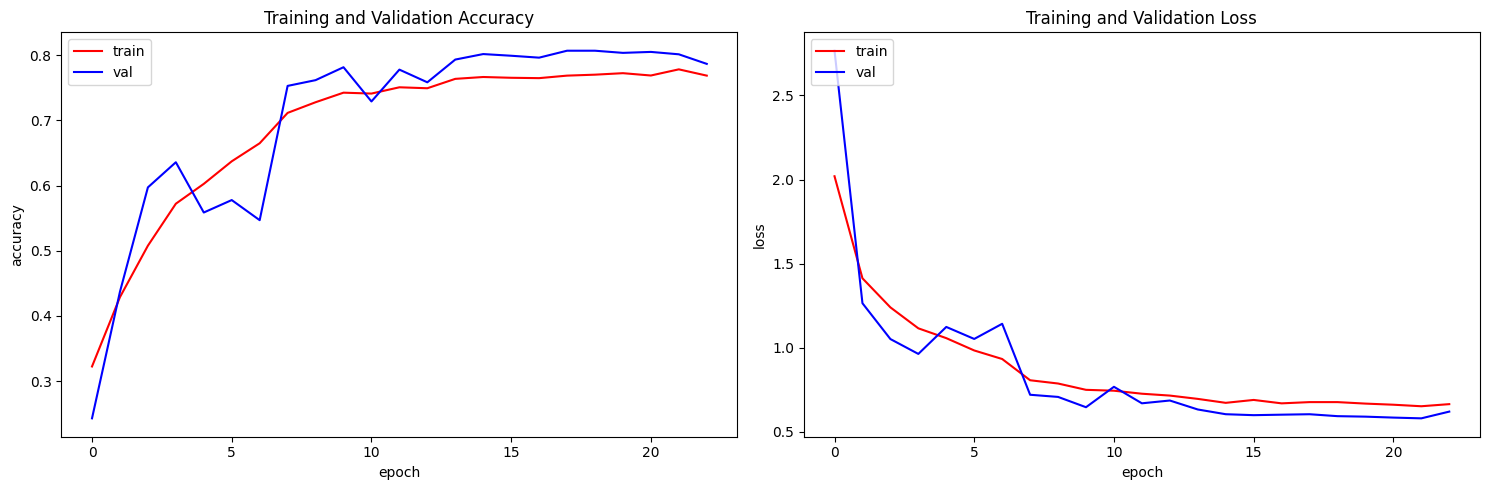

In [171]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# pass kriteria 6

              precision    recall  f1-score   support

   buildings     0.8291    0.8008    0.8147       527
      forest     0.9454    0.9853    0.9650       545
     glacier     0.7934    0.8122    0.8027       591
    mountain     0.8086    0.7533    0.7800       600
         sea     0.8382    0.8116    0.8247       568
      street     0.8263    0.8837    0.8540       576

    accuracy                         0.8397      3407
   macro avg     0.8402    0.8411    0.8402      3407
weighted avg     0.8389    0.8397    0.8388      3407



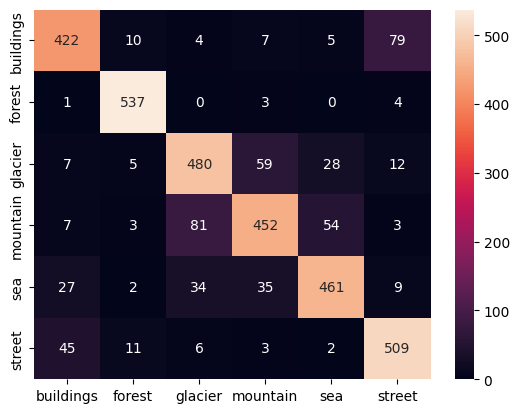

In [172]:
test_generator.reset()

preds_1 = model_1.predict(test_generator, verbose=0)

preds_class_1 = np.argmax(preds_1, axis=1)

cm_1 = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_class_1, labels=labels),
    index=category,
    columns=category
)
sns.heatmap(cm_1, annot=True, fmt="d")

print(classification_report(test_generator.classes,
                            preds_class_1,
                            target_names=category,
                            digits=4))

#### Model 2

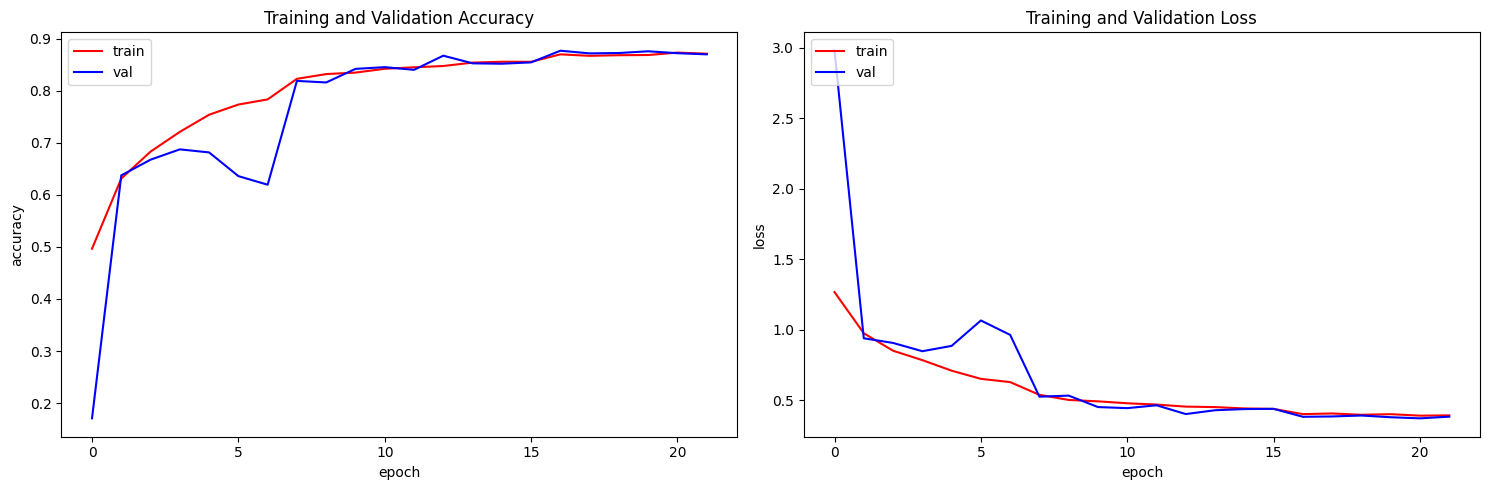

In [173]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

   buildings     0.8660    0.8710    0.8685       527
      forest     0.9489    0.9890    0.9686       545
     glacier     0.8155    0.8376    0.8264       591
    mountain     0.8325    0.8200    0.8262       600
         sea     0.9221    0.8539    0.8867       568
      street     0.8786    0.8924    0.8854       576

    accuracy                         0.8758      3407
   macro avg     0.8773    0.8773    0.8770      3407
weighted avg     0.8761    0.8758    0.8756      3407



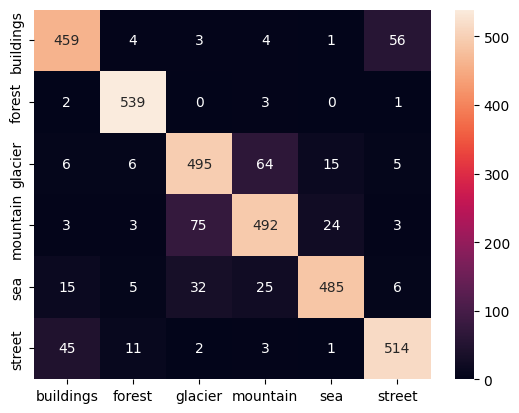

In [174]:
test_generator.reset()

preds_2 = model_2.predict(test_generator, verbose=0)

preds_class_2 = np.argmax(preds_2, axis=1)

cm_2 = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_class_2, labels=labels),
    index=category,
    columns=category
)
sns.heatmap(cm_2, annot=True, fmt="d")

print(classification_report(test_generator.classes,
                            preds_class_2,
                            target_names=category,
                            digits=4))

#### Model 3

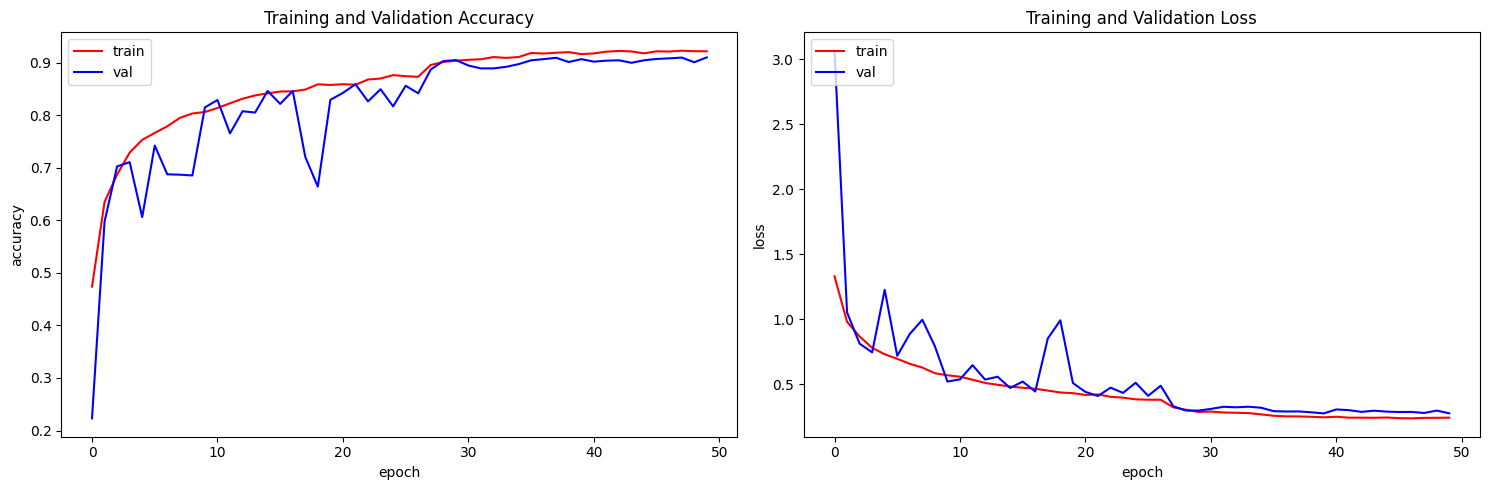

In [175]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

   buildings     0.8764    0.9013    0.8887       527
      forest     0.9748    0.9927    0.9836       545
     glacier     0.8609    0.8376    0.8491       591
    mountain     0.8729    0.8467    0.8596       600
         sea     0.9164    0.9261    0.9212       568
      street     0.9033    0.9080    0.9056       576

    accuracy                         0.9005      3407
   macro avg     0.9008    0.9020    0.9013      3407
weighted avg     0.9000    0.9005    0.9002      3407



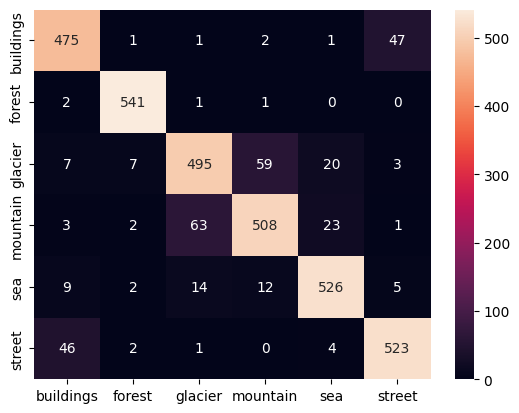

In [176]:
test_generator.reset()

preds_3 = model_3.predict(test_generator, verbose=0)

preds_class_3 = np.argmax(preds_3, axis=1)

cm_3 = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_class_3, labels=labels),
    index=category,
    columns=category
)
sns.heatmap(cm_3, annot=True, fmt="d")

print(classification_report(test_generator.classes,
                            preds_class_3,
                            target_names=category,
                            digits=4))

#### Model 4

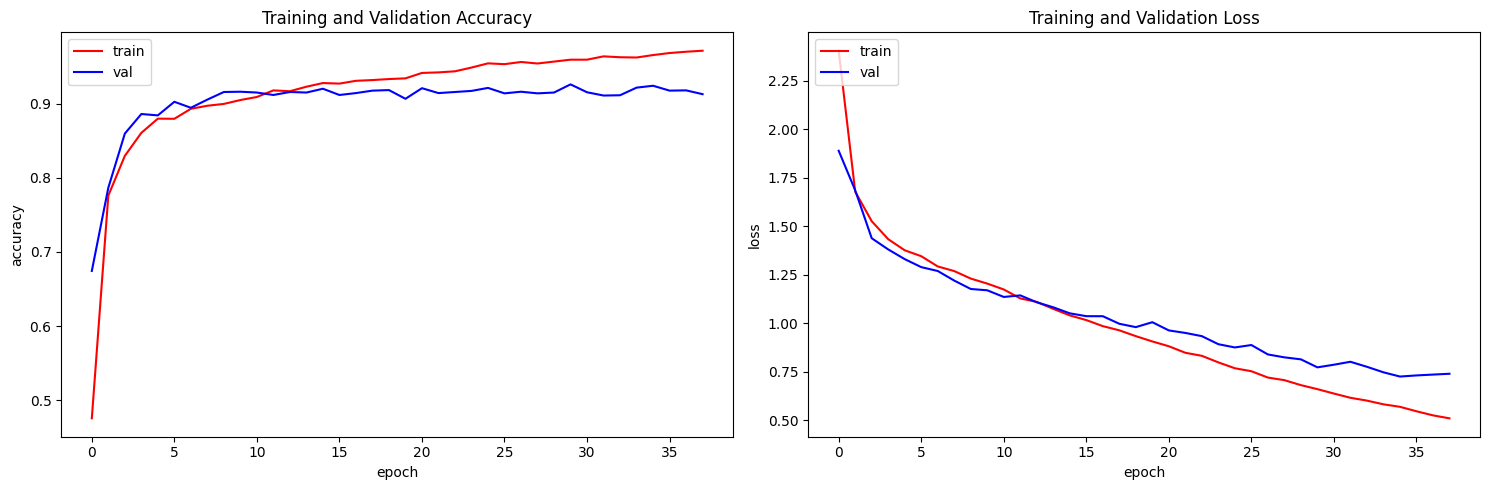

In [177]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

   buildings     0.9093    0.9507    0.9295       527
      forest     0.9801    0.9963    0.9882       545
     glacier     0.8784    0.8799    0.8791       591
    mountain     0.8862    0.8700    0.8780       600
         sea     0.9593    0.9542    0.9568       568
      street     0.9532    0.9201    0.9364       576

    accuracy                         0.9269      3407
   macro avg     0.9278    0.9285    0.9280      3407
weighted avg     0.9270    0.9269    0.9268      3407



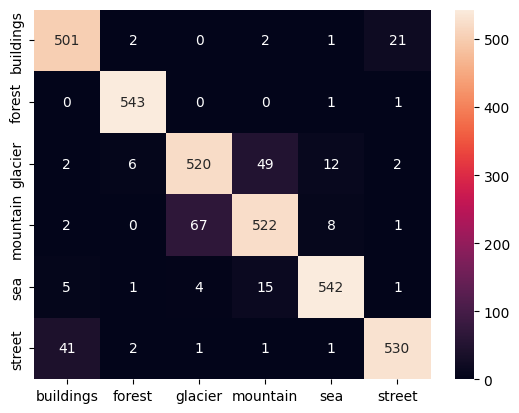

In [178]:
test_generator.reset()

preds_4 = model_4.predict(test_generator, verbose=0)

preds_class_4 = np.argmax(preds_4, axis=1)

cm_4 = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_class_4, labels=labels),
    index=category,
    columns=category
)
sns.heatmap(cm_4, annot=True, fmt="d")

print(classification_report(test_generator.classes,
                            preds_class_4,
                            target_names=category,
                            digits=4))

## Konversi Model

In [179]:
model = model_3

In [180]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [181]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

with open('tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

Saved artifact at '/tmp/tmpsmavrwzl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_3506')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138121180126992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460902032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460898960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460903952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460900112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460899728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460902800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460904720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460905296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122461283920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138122460

In [182]:
# menyimpan model dalam format TensorFlow.js
os.makedirs('tfjs_model', exist_ok=True)
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [183]:
from google.colab import files

!zip -r saved_model.zip saved_model
files.download('saved_model.zip')


!zip -r tflite.zip tflite
files.download('tflite.zip')


!zip -r tfjs_model.zip tfjs_model
files.download('tfjs_model.zip')

updating: saved_model/ (stored 0%)
updating: saved_model/variables/ (stored 0%)
updating: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: saved_model/variables/variables.index (deflated 73%)
updating: saved_model/saved_model.pb (deflated 90%)
updating: saved_model/assets/ (stored 0%)
updating: saved_model/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: tflite/ (stored 0%)
updating: tflite/model.tflite (deflated 7%)
updating: tflite/label.txt (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: tfjs_model/ (stored 0%)
updating: tfjs_model/group1-shard3of3.bin (deflated 7%)
updating: tfjs_model/group1-shard1of3.bin (deflated 8%)
updating: tfjs_model/group1-shard2of3.bin (deflated 7%)
updating: tfjs_model/model.json (deflated 93%)
  adding: tfjs_model/group1-shard1of2.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of2.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

Saving 61.jpg to 61.jpg


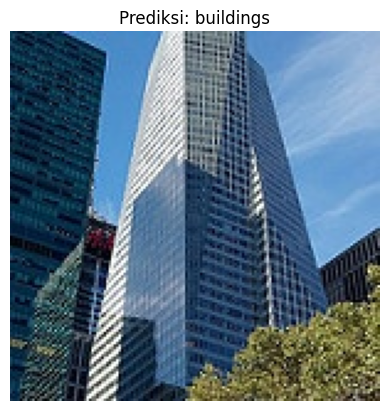

In [184]:
from google.colab import files
uploaded = files.upload()

interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')
img = img.resize((150,150))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output)
predicted_label = category[predicted_class]

plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()

Saving 63.jpg to 63.jpg


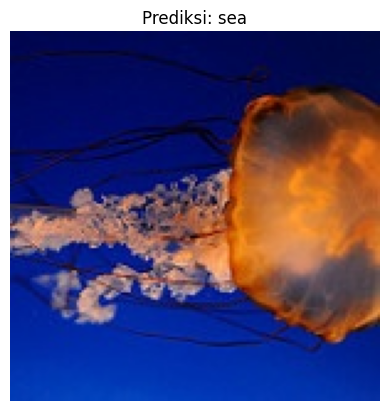

In [185]:
from google.colab import files
uploaded = files.upload()

interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')
img = img.resize((150,150))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output)
predicted_label = category[predicted_class]

plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()

Saving 252.jpg to 252.jpg


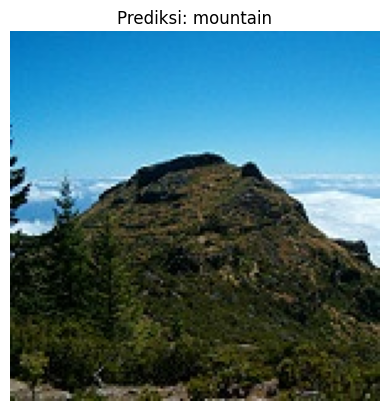

In [186]:
from google.colab import files
uploaded = files.upload()

interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')
img = img.resize((150,150))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

output = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output)
predicted_label = category[predicted_class]

plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()